In [1]:
# imports

from pathlib import Path
import torch
import pandas as pd
import numpy as np
from transformers import CLIPModel, CLIPProcessor
from peft import LoraConfig, get_peft_model
from PIL import Image
import matplotlib.pyplot as plt
from rich.console import Console

console = Console()

device = "cuda" if torch.cuda.is_available() else "cpu"
console.print(f"[bold green]Using device:[/bold green] {device}")

PROJECT_ROOT = Path("../").resolve()

VAL_FULL = PROJECT_ROOT / "data" / "processed" / "coco_val_full.csv"
VAL_20K  = PROJECT_ROOT / "data" / "processed" / "coco_val_20k.csv"

CKPT_20K = PROJECT_ROOT / "checkpoints" / "best_model.pt"
CKPT_FULL = PROJECT_ROOT / "checkpoints_full" / "best_model.pt"

/home/saber/Wox/ANLP/multimodal_ai/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda

In [2]:
df_full = pd.read_csv(VAL_FULL)
df_20k  = pd.read_csv(VAL_20K)

console.print("Full Val Size:", len(df_full))
console.print("20k Val Size:", len(df_20k))

Full Val Size: 41399

20k Val Size: 19997

In [3]:
# helper lora model

def load_lora_model(checkpoint_path):
    model = CLIPModel.from_pretrained(
        "openai/clip-vit-base-patch32",
        use_safetensors=True
    )

    peft_config = LoraConfig(
        r=8,
        lora_alpha=16,
        target_modules=["q_proj", "v_proj"],
        lora_dropout=0.1,
        bias="none"
    )

    model.text_model = get_peft_model(model.text_model, peft_config)

    state_dict = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state_dict)

    model.to(device)
    model.eval()

    return model

In [4]:
# load models

console.print("[bold cyan]Loading models...[/bold cyan]")

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Pretrained
model_pre = CLIPModel.from_pretrained(
    "openai/clip-vit-base-patch32",
    use_safetensors=True
).to(device)

# Fine-tuned 20k
model_20k = load_lora_model(CKPT_20K)

# Fine-tuned Full
model_full = load_lora_model(CKPT_FULL)

console.print("[bold green]Models loaded successfully.[/bold green]")

Loading models...

The image processor of type `CLIPImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 
Loading weights: 100%|██████████| 398/398 [00:00<00:00, 2106.20it/s, Materializing param=visual_projection.weight]                                
CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
vision_model.embeddings.position_ids | UNEXPECTED |  | 
text_model.embeddings.position_ids   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Loading weights: 100%|██████████| 398/398 [00:00<00:00, 1870.28it/s, Materializing param=visual_projection.weight]                         

Models loaded successfully.

In [7]:
def precompute_text_embeddings(model, df, batch_size=256):

    model.eval()

    captions = df["caption"].tolist()
    all_embeddings = []

    for i in range(0, len(captions), batch_size):
        batch = captions[i:i+batch_size]

        text_inputs = processor(
            text=batch,
            return_tensors="pt",
            padding=True,
            truncation=True
        ).to(device)

        with torch.no_grad():
            text_outputs = model.text_model(**text_inputs)
            pooled = text_outputs.pooler_output
            text_emb = model.text_projection(pooled)

        text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)

        all_embeddings.append(text_emb.cpu())  # MOVE TO CPU

        del text_inputs, text_outputs, text_emb
        torch.cuda.empty_cache()

    all_embeddings = torch.cat(all_embeddings, dim=0)

    return all_embeddings, captions

In [10]:
def retrieve_with_cached(model, image_path, text_emb_cpu, captions, top_k=5):

    model.eval()

    image = Image.open(image_path).convert("RGB")

    image_inputs = processor(
        images=image,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        vision_outputs = model.vision_model(**image_inputs)
        pooled_output = vision_outputs.pooler_output
        image_emb = model.visual_projection(pooled_output)

    image_emb = image_emb / image_emb.norm(dim=-1, keepdim=True)

    # Move image embedding to CPU for similarity
    image_emb = image_emb.cpu()

    similarity = image_emb @ text_emb_cpu.T
    top_indices = similarity.squeeze().topk(top_k).indices.numpy()

    return [captions[i] for i in top_indices]


In [8]:
text_emb_pre, captions = precompute_text_embeddings(model_pre, df_full)
text_emb_20k, _ = precompute_text_embeddings(model_20k, df_full)
text_emb_full, _ = precompute_text_embeddings(model_full, df_full)

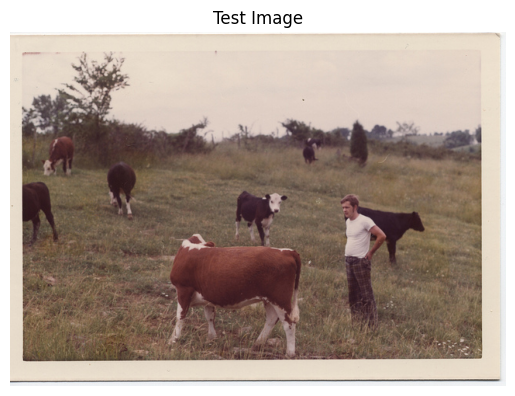

Ground Truth: a man is in a field with some cows

--- Pretrained ---
• two pictures of a man standing near a herd of cows
• a man surrounded by cows standing in a field .
• a woman standing in a field with cows that are standing and laying down.
• a man that is standing in the grass near cows.
• a person standing in a grass field with some cows.

--- Fine-tuned 20k ---
• a man is in a field with some cows
• a man that is standing in the grass near cows.
• a man surrounded by cows standing in a field .
• a woman standing in a field with cows that are standing and laying down.
• a bunch of cows in a field with a man standing near the fence.

--- Fine-tuned Full ---
• a man that is standing in the grass near cows.
• a man surrounded by cows standing in a field .
• a man is in a field with some cows
• two pictures of a man standing near a herd of cows
• the man is standing by a large herd of cows.




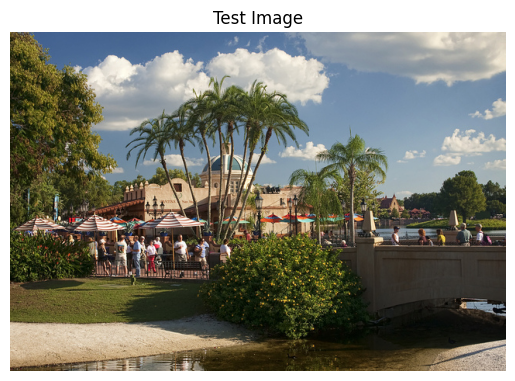

Ground Truth: people walk along a path or over a bridge near a river, palm trees, and building.

--- Pretrained ---
• people walk along a path or over a bridge near a river, palm trees, and building.
• a beach plaza with pedestrians and onlookers standing around.
• a resort shopping area has crowds walk busily through it
• a waterfront crowded with boats and vendors stalls shaded with umbrellas.
• a overhead image of people gathered in an open air restaurant.

--- Fine-tuned 20k ---
• people walk along a path or over a bridge near a river, palm trees, and building.
• a resort with palm trees, bridge, people and bushes.
• a crowd of people standing next to a body of water.
• a group of people gather around the dock.
• a crowd of people walking over a bridge.

--- Fine-tuned Full ---
• people walk along a path or over a bridge near a river, palm trees, and building.
• a resort with palm trees, bridge, people and bushes.
• people lined up on a ramp over water.
• a group of duck shaped boa

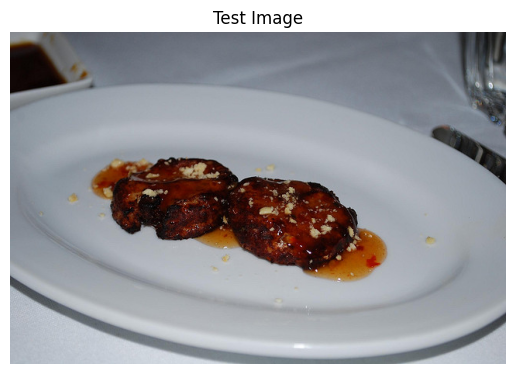

Ground Truth: a plate topped with two pieces of meat covered in sauce.

--- Pretrained ---
• a plate of bacon wrapped food sitting atop a table.
• a food entree is served on a plate.
• a food entree is served on a plate.
• a food entree is shown on top of a plate.
• a glazed donut is being served on a small plate.

--- Fine-tuned 20k ---
• a plate topped with two pieces of meat covered in sauce.
• a plate of bacon wrapped food sitting atop a table.
• fine food served with sauce on a white plate
• a white plate covered in pieces of uncooked chicken.
• some delicacy is on a small white plate on a table.

--- Fine-tuned Full ---
• some delicacy is on a small white plate on a table.
• fine food served with sauce on a white plate
• a plate of bacon wrapped food sitting atop a table.
• there is a foreign food sitting on a white plate.
• some food is sitting on a white plate




In [11]:
# test on images

sample_df = df_full.sample(3, random_state=42).reset_index(drop=True)

for idx in range(len(sample_df)):
    image_path = sample_df.iloc[idx]["image_path"]
    ground_truth = sample_df.iloc[idx]["caption"]

    plt.imshow(Image.open(image_path))
    plt.axis("off")
    plt.title("Test Image")
    plt.show()

    print("Ground Truth:", ground_truth)

    print("\n--- Pretrained ---")
    for c in retrieve_with_cached(model_pre, image_path, text_emb_pre, captions):
        print("•", c)

    print("\n--- Fine-tuned 20k ---")
    for c in retrieve_with_cached(model_20k, image_path, text_emb_20k, captions):
        print("•", c)

    print("\n--- Fine-tuned Full ---")
    for c in retrieve_with_cached(model_full, image_path, text_emb_full, captions):
        print("•", c)

    print("\n" + "="*80 + "\n")

# Test on test data set

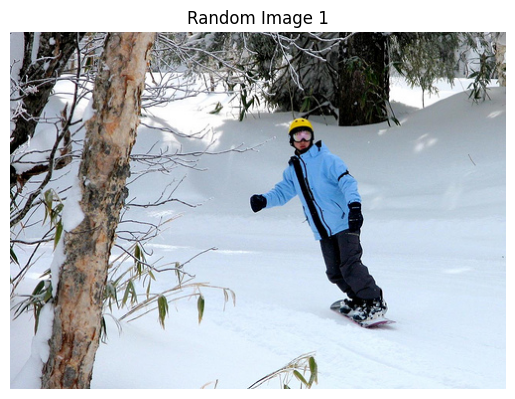


--- Pretrained ---
• a man in black jacket standing on a snowboard next to trees.

--- Fine-tuned 20k ---
• a man on a snowboard on a snowy ground in front of trees.

--- Fine-tuned Full ---
• a man on a snowboard on a snowy ground in front of trees.


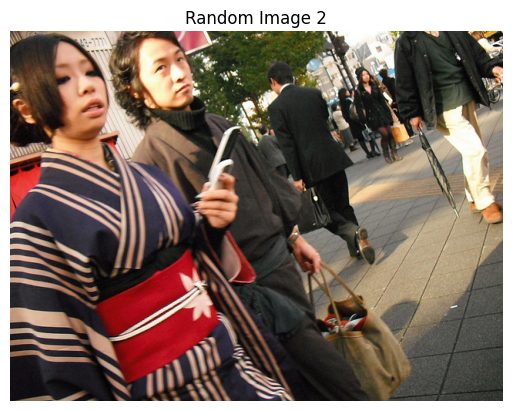


--- Pretrained ---
• a girl is smiling and walking while carrying a dog in her bag.

--- Fine-tuned 20k ---
• women dressed in japanese costumes walk on a city street under umbrellas.

--- Fine-tuned Full ---
• the woman is carrying a brown dog in her purse.


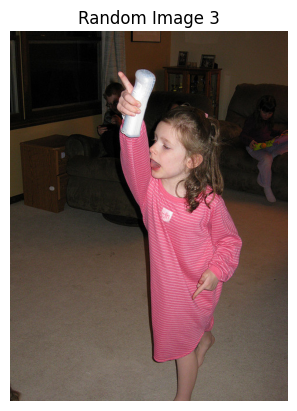


--- Pretrained ---
• a young girl points a nintendo wii remote at the camera.

--- Fine-tuned 20k ---
• a young little girl enjoys playing her wii

--- Fine-tuned Full ---
• a young girl points a nintendo wii remote at the camera.


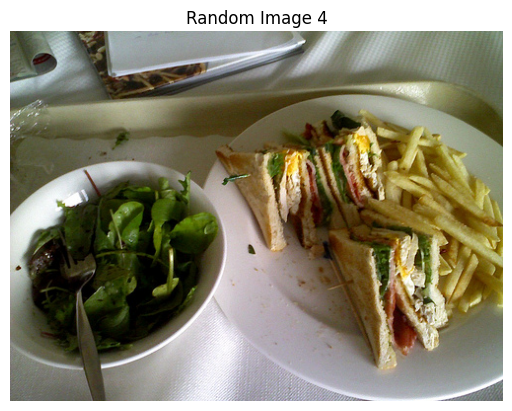


--- Pretrained ---
• a prepared lunch sits on a tray, with sandwich and fries.

--- Fine-tuned 20k ---
• a large sandwich with fries and a small salad.

--- Fine-tuned Full ---
• a china plate holds an egg salad sandwich and french fries.


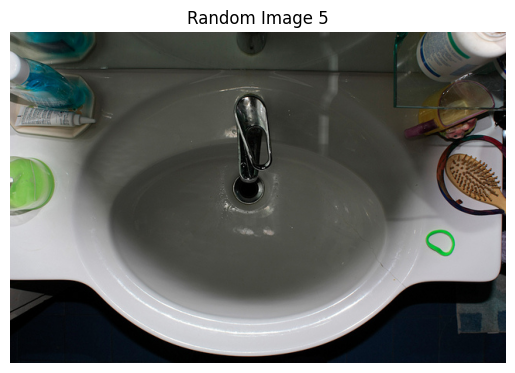


--- Pretrained ---
• a chrome sink with a bowl, a sponge and two spoons

--- Fine-tuned 20k ---
• a view of a sink that has some toothbrushes on it.

--- Fine-tuned Full ---
• a bowl shaped sink standing in front of a faucet and tiled counter top


In [21]:
from PIL import Image
import matplotlib.pyplot as plt
import random

RANDOM_IMAGE = PROJECT_ROOT / "data" / "COCO" / "test2014"


# Get list of all jpg images
all_images = list(RANDOM_IMAGE.glob("*.jpg"))

# Randomly select 5 unique images
sample_images = random.sample(all_images, 5)

for i, img_path in enumerate(sample_images):
    img = Image.open(img_path).convert("RGB")
    
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Random Image {i+1}")
    plt.show()

    print("\n--- Pretrained ---")
    top_pre = retrieve_with_cached(
        model_pre,
        img_path,
        text_emb_pre,
        captions,
        top_k=1
    )[0]
    print("•", top_pre)


    print("\n--- Fine-tuned 20k ---")
    top_20k = retrieve_with_cached(
        model_20k,
        img_path,
        text_emb_20k,
        captions,
        top_k=1
    )[0]
    print("•", top_20k)


    print("\n--- Fine-tuned Full ---")
    top_full = retrieve_with_cached(
        model_full,
        img_path    ,
        text_emb_full,
        captions,
        top_k=1
    )[0]
    print("•", top_full)
